### Some imports

In [2]:
import plaidml.keras
from keras.callbacks import ModelCheckpoint

plaidml.keras.install_backend()

from keras.models import Sequential
from keras.layers import Cropping2D, Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D

import matplotlib.pyplot as plt
import numpy as np
import csv
import cv2
import random

### Load training data

Split data into training set and validation set at random

In [3]:

# Training data was generated for different scenarios for each track;
# to make it easier to organize or re-record data, we split up data across multiple files
training_data_files = [
    './training-data-new/track-1-forwards/driving_log.csv',
    './training-data-new/track-1-reverse/driving_log.csv',
    './training-data-new/track-1-recovery/driving_log.csv',
    './training-data-new/track-1-curves/driving_log.csv',
    './training-data-new/track-2-forwards/driving_log.csv',
    './training-data-new/track-2-reverse/driving_log.csv',
    './training-data-new/track-2-recovery/driving_log.csv',
    './training-data-new/track-2-curves/driving_log.csv',
]

lines = []
# Iterate through each file and combine all the training data lines together
for i in range(len(training_data_files)):
    with open(training_data_files[i]) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)

# Output summary of what was just read into memory, for sanity check purposes
print('Read {} lines'.format(len(lines)))

# We add/subtract correction_factor from the steering angle measurement to generate new measurements
# for the side camera images
correction_factor = 0.2

# percentage of images we want to use for validation
validation_fraction = 0.25

def validation_or_training(training, validation, data):
    """
    Training, validation, and data are all tuples; at random we put data into the training or validation set
    """
    is_validation = True if random.uniform(0, 1.0) < validation_fraction else False
    if is_validation:
        validation[0].append(data[0])
        validation[1].append(data[1])
    else:
        training[0].append(data[0])
        training[1].append(data[1])

# Vars to collect the original + augumented images and measurements
X_train, y_train = [], []
X_valid, y_valid = [], []
for line in lines:
    # Image 1 = center, image 2 = left camera, image 3 = right camera
    # From 3 images (center, left, right) we create 6 images (original/flipped versions for each)
    measurement = float(line[3])

    # Center
    center_image = plt.imread(line[0])
    validation_or_training((X_train, y_train), (X_valid, y_valid), (center_image, measurement))
    validation_or_training((X_train, y_train), (X_valid, y_valid), (cv2.flip(center_image, 1), -measurement))

    # Left
    left_image = plt.imread(line[1])
    validation_or_training((X_train, y_train), (X_valid, y_valid), (left_image, measurement + correction_factor))
    validation_or_training((X_train, y_train), (X_valid, y_valid), (cv2.flip(left_image, 1), -(measurement + correction_factor)))

    # Right
    right_image = plt.imread(line[2])
    validation_or_training((X_train, y_train), (X_valid, y_valid), (right_image, measurement - correction_factor))
    validation_or_training((X_train, y_train), (X_valid, y_valid), (cv2.flip(right_image, 1), -(measurement - correction_factor)))

print('Training data size: {}'.format(len(X_train)))
print('Validation data size: {}'.format(len(X_valid)))


Read 19509 lines
Training data size: 88019
Validation data size: 29035


### Turn training/validation data into numpy arrays

In [21]:
# The images are the source data, the steering measurements are the labels to train against
X_train = np.array(X_train)
y_train = np.array(y_train)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

print('Done')

Done


### Define and compile model

Basically the nVidia network from https://devblogs.nvidia.com/deep-learning-self-driving-cars/ with dropout in the convolutional layers

In [32]:
model = Sequential([
    Lambda(lambda x: x / 255.0 - 0.5, output_shape=(160, 320, 3)),
    Cropping2D(cropping=((60, 25), (0, 0))),
    Conv2D(filters=24, kernel_size=(5, 5), activation='relu', strides=(2, 2)),
    Dropout(0.3),
    Conv2D(filters=36, kernel_size=(5, 5), activation='relu', strides=(2, 2)),
    Dropout(0.3),
    Conv2D(filters=48, kernel_size=(5, 5), activation='relu', strides=(2, 2)),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Flatten(),
    Dense(100),
    Dense(50),
    Dense(10),
    Dense(1)
])

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# add a checkpoint to save weights when the validation loss is at its lowest
checkpointer = ModelCheckpoint(
    filepath='best-weights-shuffled-more-epochs.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)


### Train model

In [33]:
history_object = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), shuffle=True, epochs=10, batch_size=64, callbacks=[checkpointer])
model.save('model-retrained-shuffled-more-epochs.h5')

Train on 88019 samples, validate on 29035 samples
Epoch 1/10
88019/88019 [==============================] - 1404s 16ms/step - loss: 0.0625 - acc: 0.0128 - val_loss: 0.0529 - val_acc: 0.0128

Epoch 00001: val_loss improved from inf to 0.05287, saving model to best-weights-shuffled-more-epochs.h5
Epoch 2/10
88019/88019 [==============================] - 1383s 16ms/step - loss: 0.0526 - acc: 0.0139 - val_loss: 0.0497 - val_acc: 0.0130

Epoch 00002: val_loss improved from 0.05287 to 0.04973, saving model to best-weights-shuffled-more-epochs.h5
Epoch 3/10
88019/88019 [==============================] - 1395s 16ms/step - loss: 0.0490 - acc: 0.0140 - val_loss: 0.0474 - val_acc: 0.0140

Epoch 00003: val_loss improved from 0.04973 to 0.04739, saving model to best-weights-shuffled-more-epochs.h5
Epoch 4/10
88019/88019 [==============================] - 1347s 15ms/step - loss: 0.0461 - acc: 0.0147 - val_loss: 0.0430 - val_acc: 0.0136

Epoch 00004: val_loss improved from 0.04739 to 0.04300, saving 

### Plot the training and validation loss for each epoch

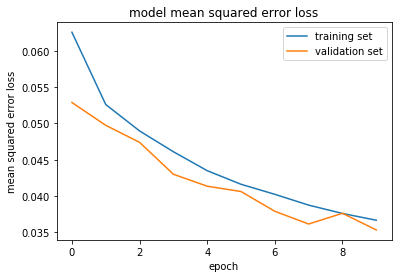

In [34]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()